# 1. DE_Exercise_1 : Extreme_Scalability_Spark_optimization 실습

※의도적으로 데이터 왜곡(skew,치우침)을 일으켜 OOM(Out of Memory)을 낸 뒤 이를 최적화하는 케이스 스터디를 진행함.

In [1]:
# 1. PySpark 설치
!pip install pyspark

# 2. Spark UI 등을 보기 위해 가끔 필요한 라이브러리(선택 사항)
!pip install findspark

# cf.) Spark는 Scala로 만들어졌고, JVM(Java Virtual Machine) 위에서 돌아감. Colab에서는 Java가 이미 설치되어있으므로, 따로 자바 설치는 안 해도 됨.
# pyspark만 설치하면 됨.

## 1-1. 정상적으로 잘 돌아가는 케이스

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "5") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
data_skewed = []
for _ in range(1000000):
  data_skewed.append((0,"Big Data Content"))

for i in range(1,101):
  data_skewed.append((i,f"small Data {i}"))

df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)


# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.




1000100

## 1-2. 데이터 증폭: 'for _ in range(10000000)' -> 천만건으로 증폭

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "5") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
data_skewed = []
for _ in range(10000000): # (※변경지점)100만건 -> 100만건으로 증폭.
  data_skewed.append((0,"Big Data Content"))

for i in range(1,101):
  data_skewed.append((i,f"small Data {i}"))

df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)


# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.




10000100

## 1-3. 메모리 압박: '.config("spark.executor.memory", "512m") -> 512MB로 메모리 낮춤.

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!) -> (※변경지점)1G -> 512m으로 수정.
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "512m") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "5") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
data_skewed = []
for _ in range(1000000):
  data_skewed.append((0,"Big Data Content"))

for i in range(1,101):
  data_skewed.append((i,f"small Data {i}"))

df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)


# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.

1000100

## 1-4. 파티션 집중:'.config("spark.sql.shuffle.partitions", "1") -> 파티션 갯수를 5 -> 1로 낮춤. 모든 데이터를 하나의 파티션으로 몰아넣는 가장 잔인한 방법임.

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!) -> (※변경지점) Partition 갯수를 5 -> 1으로 수정.
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "1") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
data_skewed = []
for _ in range(1000000):
  data_skewed.append((0,"Big Data Content"))

for i in range(1,101):
  data_skewed.append((i,f"small Data {i}"))

df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)


# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.

1000100

## ⭐1-5. 위 3가지를 전부 다 섞어서 '임계점(threshold)'를 돌파해보자!

※cf.) 위 각각의 1-2 ~ 1-4까지의 실험을 해봤을 때, 결과는 성공적으로 나오긴 했다. 하지만, 1-2의 경우에는 2분이 걸렸고, 1-3,1-4는 상대적으로 훨씬 빠른 17,16초가 걸렸다.

이를 분석해본 결과,

1-2의 경우, 2분이라는 시간이 걸린 것은 '**병목(bottleneck)**' 현상이 발생한 것이다. 이 2분이라는 시간은 데이터 엔지니어링 세계에서 "비효율이 발생하고 있다."라는 강력한 신호이다. 지금은 성공했지만, 데이터가 1억 건이 되면 20분이 아니라 시스템이 아예 멈춰버릴 수도 있다.

1-3,1-4의 경우 상대적으로 빠른 17,16초가 나온 이유는 단순 문자열 100만건 데이터는 메모리상에서 수십MB 수준이다. Spark는 512MB라는 좁은 공간에서도 데이터를 쪼개서 처리하거나(1-3), 정 안 되면 디스크(하드디스크->HDD,SSD)를 임시로 쓰는 '**Spill to Disk(Disk쪽으로 흘린다)**' 기법을 써서 어떻게든 성공시켜버린다. 하지만, **엔지니어에게는 '안 터지는 것'보다 '비효율적으로 돌아가면서 돈(시간)을 쓰는 것'이 더 무서운 일일 수 있다.**



```
1.range: 100만건 -> 3000만건
2..config("spark.executor.memory", "512m")
3..config("spark.sql.shuffle.partitions", "1")
4. 집계(Aggregation) 추가 -> 셔플을 더 강하게 유도.
```





In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "512m") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "1") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
data_skewed = []
for _ in range(30000000):
  data_skewed.append((0,"Big Data Content"))

for i in range(1,101):
  data_skewed.append((i,f"small Data {i}"))

df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)

## (새로운 추가 부분!) 그룹화 연산을 추가하면 메모리 부하가 극대화 됨!
final_result = result.groupBy('id').count()
final_result.show()

# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
#result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.

KeyboardInterrupt: 

위의 코드는 계속 잘 돌아가지만, 너무 오래걸려서 내가 직접 kill(중단)했다.

(6~7분 즈음에 kill함.)

※Q. 엄청 오래 걸리는데, 이거 에러는 안 나는 거 같고 어떻게든 돌리려 하는 거 같은데, 에러 나오려면 바로 에러뜨니 아니면 좀 오래 기달려야 해?

※A. Google Gemini Gems 답변

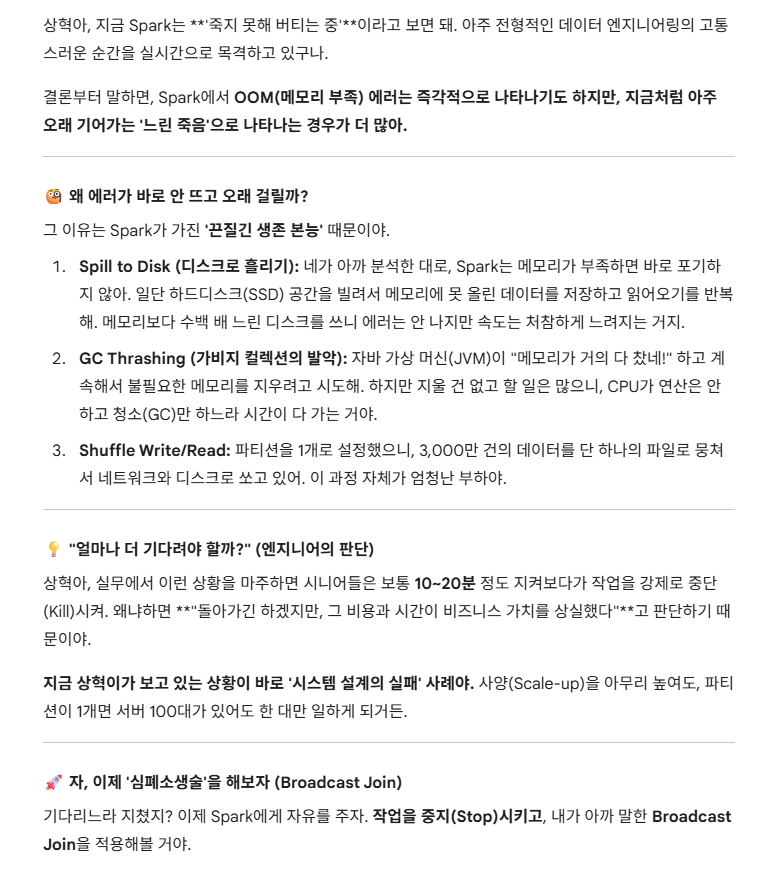



# 2. 심폐소생술 - 'BroadCast Join' 적용하기

※왜 broadcast join이냐?

->지금 터지는 이유는 df_skewed(3000만 건)를 셔플해서 옮기려고 하기 때문임.

->하지만, df_small은 고작 101건임.

->**해법**: 3000만건을 움직이지 말고, 101건짜리 작은 테이블을 모든 일꾼(broadcast, 모두에게 적용한다는 의미)에게 **복사해서 뿌려버리자!** 그러면 **셔플(shuffle) 자체가 발생하지 않는다!**

->모든 일꾼(broadcast)에게 작은 테이블을 뿌려서, 모두 broadcast하게 join을 한다는 의미임.

->일반적인 조인(shuffle Join)은 '끼리끼리 만나게 데이터를 섞자(shuffle)' 전략이다.

->그래서 일반적인 조인은 3000만 건을 네트워크로 쏘지만, broadcast 조인은 고작 101건만 네트워크로 쏘면 된다.

->셔플을 안 하니깐, id=0이 한 곳(파티션)에 몰려 터지는 일 자체가 발생하지 않는다. 데이터가 아무리 한쪽으로 치우쳐 있어도, 분산된 상태 그대로 병렬 처리가 가능해진다(그대로 join 연산하면 된다는 의미).





In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "512m") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "1") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
data_skewed = []
for _ in range(30000000):
  data_skewed.append((0,"Big Data Content"))

for i in range(1,101):
  data_skewed.append((i,f"small Data {i}"))

df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
#result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)

# 4-1. (New!) 기존의 무거운 일반 조인(Shuffle Join) 대신 broadcast() 사용
# df_small이 아주 작으므로 모든 executor에 복제해서 보낸다.
result_optimized = df_skewed.join(broadcast(df_small), "id")


# 5-1. (New!) 결과 확인
# 아까는 한참 걸렸던 count()가 얼마나 빨리 나오는지 확인해보자!
print(f"최적화된 조인 결과: {result_optimized.count()}")


## (새로운 추가 부분!) 그룹화 연산을 추가하면 메모리 부하가 극대화 됨!
#final_result = result.groupBy('id').count()
#final_result.show()

# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
#result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.

KeyboardInterrupt: 

위의 broadcast 방법으로도 3분이 넘어갈 동안 결과가 나오지 않아서 원인을 분석해보았다.

당연히 2가지 변수가 있었다.



```
1. 1개라는 파티션 갯수
2. 512MB라는 executor 메모리 제한
```

하지만 나는, **512MB executor 메모리 제한보다는 1개의 파티션 갯수에서 문제가 클 거라고 생각했다.**

왜냐하면, Gemini 말대로라면, broadcast는 작은 테이블(101개 데이터 테이블)을 모든 executor에게 준다는데, **partition이 1개면 혼자서 작업을 해버리는 거니** 결국엔 데이터 3000만에 101개 데이터 더해서 조인하는 작업 아닌가? 별 의미가 없어보인다.

Gemini의 답변 역시, 내 의견에 적극 동의하였다.

※따라서, **위 코드에서 파티션 갯수만 1 -> 4개로 늘렸다.**



```
#df.) 파티션(partition)과 CPU core의 차이

※Q. 파티션을 그러면 CPU 코어라고 생각하면 되는 거야? CPU 코어 1개당 일꾼 1개라고 생각하면 되고?

※A(Gemini). 정확하게 말하면 아니다.

개념,비유,설명
Partition (파티션),주문서(일거리),"데이터를 쪼개놓은 단위야. ""너는 이만큼만 계산해""라고 명령하는 단위지."
CPU Core (Core),요리사의 손,실제로 연산을 수행하는 물리적인 힘이야. 1개의 코어는 한 번에 1개의 파티션만 처리할 수 있어. -> 운영체제 thread(스레드) 개념
Executor (일꾼),주방(작업장),코어들을 담고 있는 프로세스야. 하나의 주방(Executor) 안에 여러 명의 요리사(Core)가 있을 수 있어. -> 운영체제 process(프로세스) 개념.

Ex.) 내가 파티션을 100개로 나눴는데, 내 컴퓨터/colab의 코어가 2개뿐이라면?

1.요리사(Core) 2명이 먼저 2개의 주문서(Partition)를 가져가서 요리한다.
2.그게 끝나면 다음 2개를 가져간다.
3.이 과정을 50번 반복해서 100개를 다 끝낸다.

Ex.) 반대로 코어는 100개인데, 파티션을 1개로 둔다면?

1명의 요리사(Core)만 죽어라 일하고, 나머지 99명의 요리사는 노는 상황이 발생한다. 아까 내가 겪은 '2분 동안 안 끝나는 상황'의 정체이다.

※보통, colab core는 2 코어다.
```





In [9]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!) -> (※새로운 수정 부분!) partition 갯수 1->4로 늘림.
# (Colab은 보통 2코어지만, 4개 정도로 쪼개는 게 효율적이다.)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "512m") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
data_skewed = []
for _ in range(30000000):
  data_skewed.append((0,"Big Data Content"))

for i in range(1,101):
  data_skewed.append((i,f"small Data {i}"))

df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
#result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)

# 4-1. (New!) 기존의 무거운 일반 조인(Shuffle Join) 대신 broadcast() 사용
# df_small이 아주 작으므로 모든 executor에 복제해서 보낸다.
result_optimized = df_skewed.join(broadcast(df_small), "id")


# 5-1. (New!) 결과 확인
# 아까는 한참 걸렸던 count()가 얼마나 빨리 나오는지 확인해보자!
print(f"최적화된 조인 결과: {result_optimized.count()}")


## (새로운 추가 부분!) 그룹화 연산을 추가하면 메모리 부하가 극대화 됨!
#final_result = result.groupBy('id').count()
#final_result.show()

# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
#result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.

KeyboardInterrupt: 

음... 하지만 이 역시도 데이터가 3000만건이라 그런지 2분이 넘어도 해결이 되지 않는다..

다른 방법을 모색해야겠다.

**※결국엔, 소프트웨어(코드: shuffle -> broadcast)로 논리적으로는 이상적이게 해결될 지 알았지만, 하드웨어적으로도 같이 손을 봐야함을 깨닫게 되었다(경험을 얻었다).**



## 2-1. 파티션 갯수 20개로 늘리기(executor 메모리는 그대로)

파티션이 4개이면 한 파티션당 750만건(3000만건/4)을 처리해야한다.

->750만 건의 데이터를 메모리에 올리고 조인 연산을 수행하기에는 512MB라는 공간이 여전히 턱없이 부족하다.

->또한 구글 colab은 보통 2개의 SPU 코어를 제공하는데, 파티션이 4개면 2개의 코어가 각각 2개씩의 파티션을 맡아서 처리하는데, 각 파티션의 크기(750만건)가 너무 커서 개별 코어가 병목에 걸릴 수 있다.



In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!) -> (※새로운 수정 부분!) partition 갯수 4->20로 늘림.
# (Colab은 보통 2코어지만, 4개 정도로 쪼개는 게 효율적이다.)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "512m") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "20") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
data_skewed = []
for _ in range(30000000):
  data_skewed.append((0,"Big Data Content"))

for i in range(1,101):
  data_skewed.append((i,f"small Data {i}"))

df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
#result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)

# 4-1. (New!) 기존의 무거운 일반 조인(Shuffle Join) 대신 broadcast() 사용
# df_small이 아주 작으므로 모든 executor에 복제해서 보낸다.
result_optimized = df_skewed.join(broadcast(df_small), "id")


# 5-1. (New!) 결과 확인
# 아까는 한참 걸렸던 count()가 얼마나 빨리 나오는지 확인해보자!
print(f"최적화된 조인 결과: {result_optimized.count()}")


## (새로운 추가 부분!) 그룹화 연산을 추가하면 메모리 부하가 극대화 됨!
#final_result = result.groupBy('id').count()
#final_result.show()

# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
#result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.

KeyboardInterrupt: 

20개의 파티션도 느리다.(4~5분 소요 중에 kill함)

->비록 코어는 2개뿐이라 20개를 순차적으로 하겠지만, 느린 디스크를 쓰지 않기 때문에(512MB 안에서, RAM에서 전부 다 처리 가능) 전체 속도는 훨씬 빨라질 거라 예상했다.

->하지만, 20개는 좀 부담스러운 거 같으니, 50개로 더 늘려서 실험해보겠다.

※이번에도 실패한다면, 어쩔 수 없이 executor memory도 1g로 늘려야겠다.

->하드웨어의 중요성도 점점 커지고 있음을 느낀다.

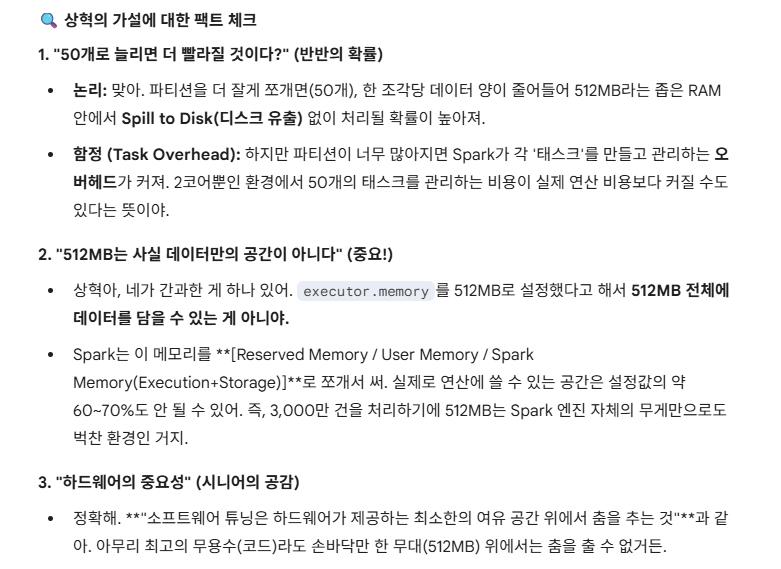

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!) -> (※새로운 수정 부분!) partition 갯수 20->50로 늘림.
# (Colab은 보통 2코어지만, 4개 정도로 쪼개는 게 효율적이다.)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "512m") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
data_skewed = []
for _ in range(30000000):
  data_skewed.append((0,"Big Data Content"))

for i in range(1,101):
  data_skewed.append((i,f"small Data {i}"))

df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
#result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)

# 4-1. (New!) 기존의 무거운 일반 조인(Shuffle Join) 대신 broadcast() 사용
# df_small이 아주 작으므로 모든 executor에 복제해서 보낸다.
result_optimized = df_skewed.join(broadcast(df_small), "id")


# 5-1. (New!) 결과 확인
# 아까는 한참 걸렸던 count()가 얼마나 빨리 나오는지 확인해보자!
print(f"최적화된 조인 결과: {result_optimized.count()}")


## (새로운 추가 부분!) 그룹화 연산을 추가하면 메모리 부하가 극대화 됨!
#final_result = result.groupBy('id').count()
#final_result.show()

# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
#result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.

KeyboardInterrupt: 

## 2-2. Executor Memory 512MB -> 1G로 늘리기



이번에도 실패했다.

executor memory를 1g로 늘려야겠다.

(나머지 설정은 그대로 할 것이다.)

※데이터 1000만건 vs 3000만건의 차이는 엄청 난 거 같다.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!) -> (※새로운 수정 부분!) partition 갯수 20->50로 늘림.
# (Colab은 보통 2코어지만, 4개 정도로 쪼개는 게 효율적이다.)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
data_skewed = []
for _ in range(30000000):
  data_skewed.append((0,"Big Data Content"))

for i in range(1,101):
  data_skewed.append((i,f"small Data {i}"))

df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
#result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)

# 4-1. (New!) 기존의 무거운 일반 조인(Shuffle Join) 대신 broadcast() 사용
# df_small이 아주 작으므로 모든 executor에 복제해서 보낸다.
result_optimized = df_skewed.join(broadcast(df_small), "id")


# 5-1. (New!) 결과 확인
# 아까는 한참 걸렸던 count()가 얼마나 빨리 나오는지 확인해보자!
print(f"최적화된 조인 결과: {result_optimized.count()}")


## (새로운 추가 부분!) 그룹화 연산을 추가하면 메모리 부하가 극대화 됨!
#final_result = result.groupBy('id').count()
#final_result.show()

# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
#result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.

KeyboardInterrupt: 

여전히 3분을 넘어도 실행을 하고 있다.

여기서 의문이 들었다. 지금 현재 할 수 있는 방법을 다 동원해서(소프트웨어 + 하드웨어) 성능 향상 실험을 해봤는데, 아직도 너무나 느리다.

물론 아직 성능 향상을 제대로 안 해서 일 수도 있겠지만, 그렇다고 해도 100만건, 1000만건, 3000만건의 **차이가 이렇게 큰가?**라는 생각이 들었다.

그러면, 시중에 나와 있는 데이터 서비스는 어떻게 돌아가는 거지란 생각이 들었다. 그들은 몇천만개보다 훨씬 많은 데이터를 다룰텐데 말이다.



---
그러면서 문득 드는 생각이 '단순 3000만개의 데이터가 아니라 **for문을 통해 3000만번의 연산의 비용이 비싸서 그런 것이 아닐까?**'라는 생각이 들었다.

※Gemini의 결론부터 말하자면, 맞다고 한다.

->python의 for문은 매우 느리다고 한다. 3000만번의 루프를 돌며 리스트에 튜플을 추가하는 작업은 CPU를 100% 점유하면서 한참 동안 데이터만 만들고 있다고 한다.

->즉, **Spark가 느린 게 아니라 python이 리스트를 만드느라 끙끙대고 있을 확률이 크다는 것**이다.

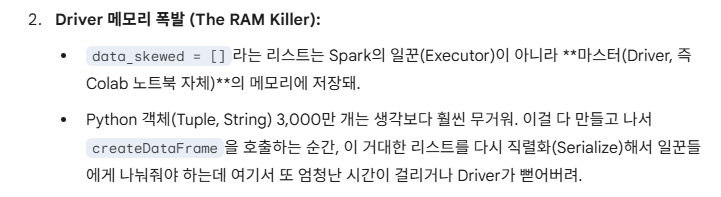




# 3. spark.range 활용하기!

데이터 엔지니어는 대량의 테스트 데이터를 만들 때 **절대로 python의 for문을 쓰지 않는다고 한다.**

대신에 **spark 엔진 자체가 병렬(=동시에)로 데이터를 생성하게 만든다고 한다.**


---


※일단은, executor memory: 1g, partition: 50, range:3000만개로 최근 설정으로 동일하게 설정하고 성공한다면 점점 줄여나가서 한계치를 찾아보도록 하겠다.

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!) -> (※새로운 수정 부분!) partition 갯수 20->50로 늘림.
# (Colab은 보통 2코어지만, 4개 정도로 쪼개는 게 효율적이다.)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2. 아주 불균형한 데이터(Skewed Data) 생성
# ID 0번이 100만 건, 나머지 ID 1~100번은 각 1건씩
# data_skewed = []
# for _ in range(30000000):
#   data_skewed.append((0,"Big Data Content"))

# for i in range(1,101):
#   data_skewed.append((i,f"small Data {i}"))

# df_skewed = spark.createDataFrame(data_skewed, ["id", "value"]) # 두 번째 인자인 '["id", "value"]'는 열(column) 이름을 정의함.

# 2-1. (New!) Python for문 대신 Spark의 내장 함수를 사용해서 데이터 3000만 건 만들기!
# 0부터 29,999,999까지 숫자를 가진 'id' 컬럼 생성(이미 분산되어 생성됨!)

##cf.)설명
# 1. spark.range(start, end): python range와 비슷하지만, 데이터 생성 자체가 각 일꾼(Executor)들에게 분산되어 동시에 진행됨.
# 3000만개의 행을 가진 '뼈대' DataFrame을 순식간에 만들어냄.(기본 컬럼명은 'id')

# 2. .withColumn("id", F.lit(0)): 원래 0~29,999,999까지 들어있던 id 컬럼의 값을 모두 숫자 '0'으로 덮어씌워버림.
# F.lit(0)은 'literal'의 약자로, 모든 행에 똑같은 상수 0을 넣으라는 명령임.
# 이 한 줄로 3000만 건의 데이터가 전부 id=0으로 몰린 '최악의 skew' 데이터를 생성함.

# 3. .withColumn("value", F.lit("Big Data Content")): value라는 이름의 새 컬럼을 만들고, 모든 행에 "Big Data Content"를 넣는다.
# 이 역시 모든 일꾼들이 자기 몫의 데이터를 병렬로 처리하므로 매우 빠름.

df_skewed = spark.range(0,30000000) \
    .withColumn("id",F.lit(0)) \
    .withColumn("value", F.lit("Big Data Content"))


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
#result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)

# 4-1. (New!) 기존의 무거운 일반 조인(Shuffle Join) 대신 broadcast() 사용
# df_small이 아주 작으므로 모든 executor에 복제해서 보낸다.
result_optimized = df_skewed.join(broadcast(df_small), "id")


# 5-1. (New!) 결과 확인
# 아까는 한참 걸렸던 count()가 얼마나 빨리 나오는지 확인해보자!
print(f"최적화된 조인 결과: {result_optimized.count()}")


## (새로운 추가 부분!) 그룹화 연산을 추가하면 메모리 부하가 극대화 됨!
#final_result = result.groupBy('id').count()
#final_result.show()

# 5. 결과 확인 (Action을 호출해야 실제 연산이 시작됨)
#result.count() # 우리가 아는 집계 함수 count(갯수 세기)가 맞음.

최적화된 조인 결과: 30000000


7초만에 나왔다...(대박)

**역시 python의 for문 연산 과정이 오래걸린 거였다.**

한번 하드웨어 용량을 더 줄여보겠다.

->그 다음에 소프트웨어(broadcast -> shuffle)로도 바꿔보자.


## 3-1. (하드웨어 다운그레이드) executor.memory -> 512m, partition -> 20개로 바꾸기.

※지저분한 필요없는 주석은 지우겠다.

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!) -> (※새로운 수정 부분!) partition 갯수 20->50로 늘림.
# (Colab은 보통 2코어지만, 4개 정도로 쪼개는 게 효율적이다.)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "512m") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "20") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2-1. (New!) Python for문 대신 Spark의 내장 함수를 사용해서 데이터 3000만 건 만들기!
# 0부터 29,999,999까지 숫자를 가진 'id' 컬럼 생성(이미 분산되어 생성됨!)

##cf.)설명
# 1. spark.range(start, end): python range와 비슷하지만, 데이터 생성 자체가 각 일꾼(Executor)들에게 분산되어 동시에 진행됨.
# 3000만개의 행을 가진 '뼈대' DataFrame을 순식간에 만들어냄.(기본 컬럼명은 'id')

# 2. .withColumn("id", F.lit(0)): 원래 0~29,999,999까지 들어있던 id 컬럼의 값을 모두 숫자 '0'으로 덮어씌워버림.
# F.lit(0)은 'literal'의 약자로, 모든 행에 똑같은 상수 0을 넣으라는 명령임.
# 이 한 줄로 3000만 건의 데이터가 전부 id=0으로 몰린 '최악의 skew' 데이터를 생성함.

# 3. .withColumn("value", F.lit("Big Data Content")): value라는 이름의 새 컬럼을 만들고, 모든 행에 "Big Data Content"를 넣는다.
# 이 역시 모든 일꾼들이 자기 몫의 데이터를 병렬로 처리하므로 매우 빠름.

df_skewed = spark.range(0,30000000) \
    .withColumn("id",F.lit(0)) \
    .withColumn("value", F.lit("Big Data Content"))


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
#result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)

# 4-1. (New!) 기존의 무거운 일반 조인(Shuffle Join) 대신 broadcast() 사용
# df_small이 아주 작으므로 모든 executor에 복제해서 보낸다.
result_optimized = df_skewed.join(broadcast(df_small), "id")


# 5-1. (New!) 결과 확인
# 아까는 한참 걸렸던 count()가 얼마나 빨리 나오는지 확인해보자!
print(f"최적화된 조인 결과: {result_optimized.count()}")


최적화된 조인 결과: 30000000


1초 만에 나온다..

**※결론: 이미 spark로 데이터를 생성한 이후부터는 병목 현상이 많이 완화되어, 하드웨어 성능을 어느 정도 다운그레이드시켜도 빠르게 잘 나오는 거 같다.**



---
그렇다면, 이번에는 소프트웨어(broadcast -> shuffle)로 바꿔서 실험해보겠다.


## 3-2. (소프트웨어 방식 변경) Broadcast -> Shuffle

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast

# 1. Spark 세션 생성(메모리를 일부러 작게 설정!) -> (※새로운 수정 부분!) partition 갯수 20->50로 늘림.
# (Colab은 보통 2코어지만, 4개 정도로 쪼개는 게 효율적이다.)
spark = SparkSession.builder \
    .appName("SkewTest") \
    .config("spark.executor.memory", "512m") \
    .config("spark.driver.memory", "1g") \
    .config("spark.sql.shuffle.partitions", "20") \
    .getOrCreate()

#appName: 앱 네임. Spark UI에서 이 이름으로 작업 표시됨.
#spark.executor.memory: 개별 일꾼(executor)이 사용할 메모리 제한.
#spark.driver.memory: 마스터(Driver)가 사용할 메모리 제한. 마스터는 데이터를 수집하거나 실행 계획을 짜는 '대장' 메모리이다.
#spark.sql.shuffle.partitions: 데이터가 섞일(shuffle) 때 생성될 조각(partition)의 갯수. 기본값은 200임.
#getOrCreate(): 기존에 만들어진 세션이 있으면 그걸 쓰고, 없으면 새로 만들라는 명령어(함수).


# 2-1. (New!) Python for문 대신 Spark의 내장 함수를 사용해서 데이터 3000만 건 만들기!
# 0부터 29,999,999까지 숫자를 가진 'id' 컬럼 생성(이미 분산되어 생성됨!)

##cf.)설명
# 1. spark.range(start, end): python range와 비슷하지만, 데이터 생성 자체가 각 일꾼(Executor)들에게 분산되어 동시에 진행됨.
# 3000만개의 행을 가진 '뼈대' DataFrame을 순식간에 만들어냄.(기본 컬럼명은 'id')

# 2. .withColumn("id", F.lit(0)): 원래 0~29,999,999까지 들어있던 id 컬럼의 값을 모두 숫자 '0'으로 덮어씌워버림.
# F.lit(0)은 'literal'의 약자로, 모든 행에 똑같은 상수 0을 넣으라는 명령임.
# 이 한 줄로 3000만 건의 데이터가 전부 id=0으로 몰린 '최악의 skew' 데이터를 생성함.

# 3. .withColumn("value", F.lit("Big Data Content")): value라는 이름의 새 컬럼을 만들고, 모든 행에 "Big Data Content"를 넣는다.
# 이 역시 모든 일꾼들이 자기 몫의 데이터를 병렬로 처리하므로 매우 빠름.

df_skewed = spark.range(0,30000000) \
    .withColumn("id",F.lit(0)) \
    .withColumn("value", F.lit("Big Data Content"))


# 3. 조인할 대상 테이블 (아주 작은 테이블)
data_small = [(i,f"Info {i}") for i in range(101)]
df_small = spark.createDataFrame(data_small, ["id", "info"])


# 4. 운명의 조인 실행 (과연 터질까?)
result = df_skewed.join(df_small, "id") # join은 '내부 공통 조인(Inner Join)'이다. 즉, 교집합 부분만(두 테이블 양쪽 모두 존재하는 id 값들만 결과 세트에 포함시킴.)

# 4-1. (New!) 기존의 무거운 일반 조인(Shuffle Join) 대신 broadcast() 사용
# df_small이 아주 작으므로 모든 executor에 복제해서 보낸다.
#result_optimized = df_skewed.join(broadcast(df_small), "id")


# 5-1. (New!) 결과 확인
# 아까는 한참 걸렸던 count()가 얼마나 빨리 나오는지 확인해보자!
print(f"최적화된 조인 결과: {result.count()}")


최적화된 조인 결과: 30000000


8초 만에 나온다.

확실히 **이번 경우에서는 broadcast가 shuffle보다는 더 빠르다는 것을 볼 수 있었다.**

**하지만, 그렇게 큰 차이는 없는 걸로 보인다.**

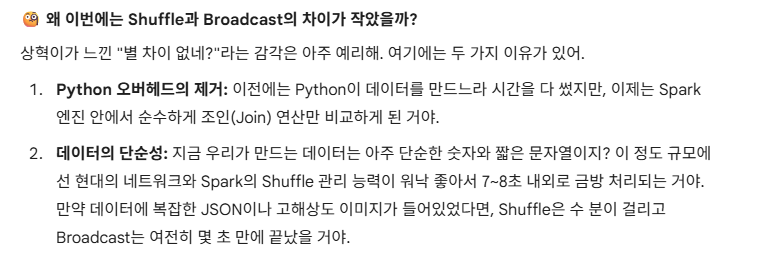

# 4. 만약 small_data(id=1~100)의 크기가 지금보다 더 크다면?

지금이야 small_data는 각 id별로 1개씩의 데이터만을 생성하여, 규모가 작지만,

**만약에 이 small_data마저 크기가 크다면, 과연 broadcast 방식이 올바를까?**

-> 'Big vs Big' join의 문제점.

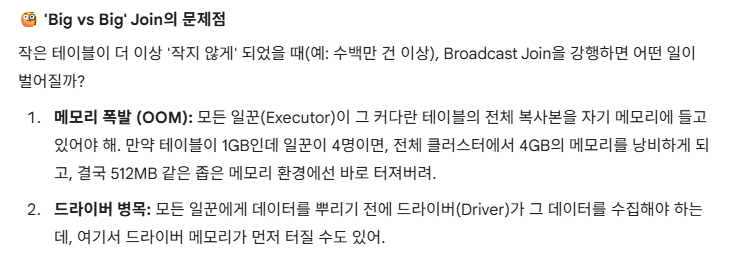

**※df_small을 100만건 정도로 키워서 Shuffle Join으로 돌아갈 수 밖에 없는 환경을 만들어보자!**

In [7]:
# 1. '작은 테이블'을 100만 건으로 증폭(이제 더이상 작지 않음)
df_big_side = spark.range(0,1000000) \
.withColumn("info", F.lit("Extra Info Data")) # withColumn(): () 안에 있는 내용으로 새로운 열을 만들거나, 기존에 있는 열을 () 안에 있는 내용으로 바꾸는(update) 함수

# 2. 기존의 3000만 건의 테이블 (id=0이 대부분)
df_skewed = spark.range(0,30000000) \
    .withColumn("id", F.lit(0)) \
    .withColumn("value", F.lit("Big Data Content"))

# 3. 이번에는 broadcast()를 빼고 '일반 조인(shuffle Join)' 실행
# spark는 테아블이 크면 자동으로 shuffle Join을 선택함.
import time

start_time = time.time()
result = df_skewed.join(df_big_side,"id")
print(f"결과 건수: {result.count()}")
print(f"Big vs Big Shuffle Join 시간: {time.time() - start_time:.2f} 초")

결과 건수: 30000000
Big vs Big Shuffle Join 시간: 0.77 초


0.77초...

executor.memory: 512m, partitions: 20으로 하드웨어 설정은 따로 건들지 않았기 때문에 바로 위 코드의 설정을 그대로 따른다.

아무래도, 단순 문자열인 것도 큰 거 같다.


# 5. 결론 및 마무리

우리가 지금까지 데이터 갯수를 늘려보고, 하드웨어 설정도 조절해보고, 소프트웨어(shuffle,broadcast)도 조절해보면서 정말 다양한 실험을 해보았다.

여기서 예상치 못하게,
**python의 for문이 생각보다 어마어마하게 비용을 많이 먹고, 느리다라는 것을 깨달았고, 거기에 더해 spark가 정말 빅데이터 관련해서 처리 능력이 최적화되어있음을 몸소 깨달았다.**

또한, 우리가 지금은 문자열 데이터로만 이용해서 데이터 크기가 몇천만개더라도 수십MB 정도 밖에 안 되는 것도 있고, JSON 타입이거나 다른 타입의 데이터들로는 또 차이가 많이 날 수도 있음을 깨달았다.



---
이렇게 해서 Exercise_1 실습을 여기서 마무리하도록 하겠다.

**Data Skewed(데이터 왜곡,치우침)에 대해서 소프트웨어/하드웨어적으로 둘 다 유익하게 알아보는 시간이 되어서 정말 뜻깊었다.**


